In [1]:
import argparse
import json
import logging
import math
import os
import pickle
import random
import time
from datetime import datetime
from itertools import cycle
from tqdm import tqdm

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
import torchdyn
import wandb
from datasets import load_from_disk
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import issparse
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

# Prepare data

In [2]:
def mmd_rbf(X, Y, gamma=2.0, num_comps=50):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    XX = pairwise.rbf_kernel(X_red, X_red, gamma)
    YY = pairwise.rbf_kernel(Y_red, Y_red, gamma)
    XY = pairwise.rbf_kernel(X_red, Y_red, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def compute_wass(X, Y, reg=0.01, num_comps=50):
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    # Compute the cost matrix (squared Euclidean distances)
    M = ot.dist(X_red, Y_red, metric='sqeuclidean')
    
    # Normalize the cost matrix
    M /= M.max()
    
    # Assume uniform distribution of weights
    a = np.ones((X_red.shape[0],)) / X_red.shape[0]
    b = np.ones((Y_red.shape[0],)) / Y_red.shape[0]
    
    wasserstein_dist = ot.sinkhorn2(a, b, M, reg)
    return wasserstein_dist

def compute_gw(X, Y, num_comps=50):
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    C1 = ot.dist(X_red, X_red, metric='euclidean')
    C2 = ot.dist(Y_red, Y_red, metric='euclidean')

    # Uniform distributions over samples
    p = ot.unif(X_red.shape[0])
    q = ot.unif(Y_red.shape[0])

    # Compute Gromov-Wasserstein distance
    gw_dist = ot.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return gw_dist

In [11]:
adata = sc.read_h5ad("/home/dfl32/project/ifm/cinemaot_data/raw_cinemaot.h5ad")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=20)

hvgs = adata.var['highly_variable']

if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

sample_indices = np.random.choice(expression_data.shape[0], size=5000, replace=False)
expression_data = expression_data[sample_indices]

# pca = PCA(n_components=768, svd_solver='randomized')
# pca.fit(expression_data)
# print("fit_done")

save_dir = "/home/dfl32/project/ifm/projections"
save_name = f"pcadim768_numsamples10000.pickle"
save_path = os.path.join(save_dir, save_name)
with open(save_path, 'rb') as f:
    pca = pickle.load(f)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
dataset = load_from_disk("/home/dfl32/scratch/cinemaot_data/ifm_hf_ds/gaussian_pca768_normFalse_hf_ds")
data_array = np.array(dataset['expr'])

sample_indices = np.random.choice(data_array.shape[0], size=5000, replace=False)

# Subset the AnnData object
dense_array = data_array[sample_indices]

# # Convert to a dense matrix and extract the numpy array
# dense_array = sampled_adata.X.toarray() if issparse(sampled_adata.X) else sampled_adata.X

# Run inference

In [5]:
model_dir = "/home/dfl32/scratch/training-runs/simple_ifm/cfm-mlp-2024-05-17_23-11-41/"
checkpoint = 100000
model_path = os.path.join(model_dir, f"checkpoint-{checkpoint}.pt")
device = torch.device("cuda")
input_dim = 768
mlp_width = 1024

model = MLP(
    dim=input_dim,
    w=mlp_width, 
    time_varying=True
).to(device)
print(model.load_state_dict(torch.load(model_path)))
model.eval()

<All keys matched successfully>


MLP(
  (net): Sequential(
    (0): Linear(in_features=769, out_features=1024, bias=True)
    (1): SELU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): SELU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): SELU()
    (6): Linear(in_features=1024, out_features=768, bias=True)
  )
)

In [6]:
node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
batch_size = 100
num_steps = 50
with torch.no_grad():
    cells = []
    for step in tqdm(range(num_steps)):
        x0 = torch.normal(0.0, 1.0**0.5, size=(batch_size, input_dim)).to(device)
        traj = node.trajectory(
                    x0,
                    t_span=torch.linspace(0, 1, 100),
                ) # shape num_time_points x batch_size x output_dim
        cells.append(traj[-1, :, :].cpu().numpy())
    cells = np.concatenate(cells, axis=0)

100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


In [7]:
cells_ag = pca.inverse_transform(cells)

In [8]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_statistics(array1, array2):
    # Ensure the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The input arrays must have the same shape.")
    
    # Calculate row-wise means
    mean1 = np.mean(array1, axis=0)
    mean2 = np.mean(array2, axis=0)
    
    # Calculate R^2
    correlation_matrix = np.corrcoef(mean1, mean2)
    r2 = correlation_matrix[0, 1] ** 2
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(mean1, mean2)
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(mean1, mean2)
    
    return r2, pearson_corr, spearman_corr


r2, pearson_corr, spearman_corr = compute_statistics(cells_ag, expression_data)
print(f"R^2: {r2}")
print(f"Pearson correlation: {pearson_corr}")
print(f"Spearman correlation: {spearman_corr}")


R^2: 0.9967447199859394
Pearson correlation: 0.9983710332265928
Spearman correlation: 0.9708413718946873


In [10]:
r2, pearson_corr, spearman_corr = compute_statistics(cells, dense_array)
print(f"PCA R^2: {r2}")
print(f"PCA Pearson correlation: {pearson_corr}")
print(f"PCA Spearman correlation: {spearman_corr}")

PCA R^2: 0.07538190835572596
PCA Pearson correlation: 0.27455765943736876
PCA Spearman correlation: 0.1766419491525424


In [12]:
r2, pearson_corr, spearman_corr = compute_statistics(cells_ag[:, hvgs], expression_data[:, hvgs])
print(f"HVGS R^2: {r2}")
print(f"HVGS Pearson correlation: {pearson_corr}")
print(f"HVGS Spearman correlation: {spearman_corr}")

HVGS R^2: 0.7314683797530417
HVGS Pearson correlation: 0.855259247101744
HVGS Spearman correlation: 0.7593984962406014


In [26]:
print("MMD", mmd_rbf(cells, dense_array))
print("Wass", compute_wass(cells, dense_array))

MMD 0.000399999994947575
Wass 0.14953124412245256


In [13]:
pcs = [i for i in range(10, 101, 10)]
for pc in pcs:
    # mmd = mmd_rbf(cells, dense_array, gamma=0.01, num_comps=pc)
    # print(f"PCS {pc} MMD {mmd}")
# for pc in pcs:
#     wass = compute_wass(cells, dense_array, num_comps=pc)
#     print(f"PCS {pc} Wass {wass}")
# for pc in pcs:
    wass = compute_gw(cells, dense_array, num_comps=pc)
    print(f"PCS {pc} GW {wass}")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


PCS 10 GW 6.279093161058205


KeyboardInterrupt: 

In [22]:
cfm_adata = anndata.AnnData(X=cells)
cfm_adata.obs['sample'] = ['cfm']*len(cells)
simple_sampled_adata = anndata.AnnData(X=dense_array)
simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
combined_norm_adata = anndata.concat([simple_sampled_adata, cfm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


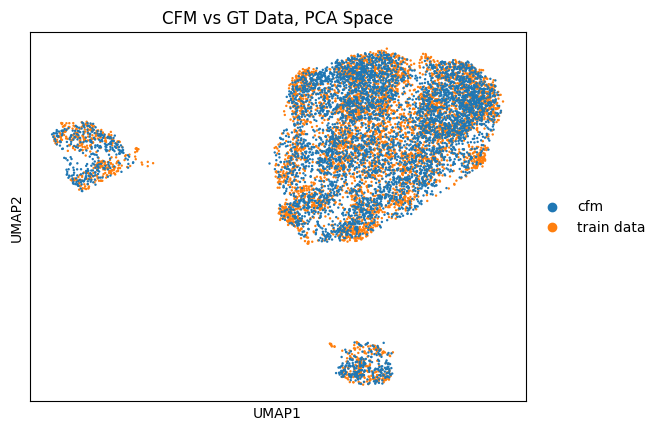

In [23]:
sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['sample'], wspace=0.5, title="CFM vs GT Data, PCA Space")

In [24]:
cfm_inverse_transformed = pca.inverse_transform(cfm_adata.X)
print("transform done")
cfm_inverse_adata = anndata.AnnData(X=cfm_inverse_transformed)
cfm_inverse_adata.obs['sample'] = ['cfm']*cfm_inverse_transformed.shape[0]
original_adata = anndata.AnnData(X=expression_data[:len(cfm_inverse_adata)])
original_adata.obs['sample'] = ['original']*len(original_adata)
combined_original_adata = anndata.concat([original_adata, cfm_inverse_adata])

transform done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


pca done
knn done


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


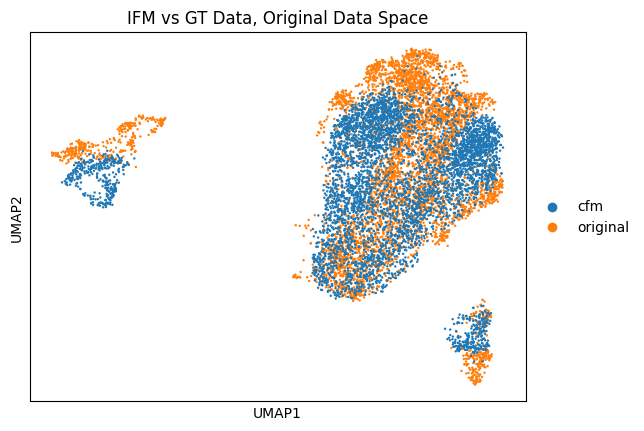

In [25]:
sc.pp.pca(combined_original_adata)
print("pca done")
sc.pp.neighbors(combined_original_adata)
print("knn done")
sc.tl.umap(combined_original_adata)
sc.pl.umap(
    combined_original_adata,
    color=['sample'],
    wspace=0.5,
    title="IFM vs GT Data, Original Data Space"
)

In [27]:
print("MMD", mmd_rbf(cfm_inverse_transformed, expression_data[:len(cfm_inverse_adata)]))
print("Wass", compute_wass(cfm_inverse_transformed, expression_data[:len(cfm_inverse_adata)]))

MMD 0.00039999998989515007
Wass 0.3898610226509943
